# Projeto MTR

0. Pegar o dataset de heart disease (e possivelmente de airbnb)
1. Manipular os dados para deixá-los prontos para treinamento por modelos de ML 
2. Pesquisar e escolher os modelos para serem testados (de preferência modelos que sabemos ter erros correlacionados)
3. Treinar modelos (tentar achar os melhores hiperparâmetros, usar validação cruzada de 5 ou 10 folds)
4. Construir assessores (treinados para tentar prever o erro dos modelos) (também tentar achar melhores hiperparâmetros):

    4.1. Um assessor para cada modelo (RandomForestRegressor ou algum outro)
    
    4.2. Um assessor multi-target para todos os modelos (RegressorChains (outputs relacionados) **e** Single Target Method (outputs independentes))
    
    4.3. Um assessor para cada "família" ou grupo de modelos de ML com erros correlacionados (RegressorChains)

5. Coletar resultados e tirar conclusões para apresentar

## Imports e funções

In [1]:
from utils import *

# Dataset

**Attribute Information:**

- 1. age       
- 2. sex       
- 3. chest pain type  (4 values)       
- 4. resting blood pressure  
- 5. serum cholestoral in mg/dl      
- 6. fasting blood sugar > 120 mg/dl       
- 7. resting electrocardiographic results  (values 0,1,2)
- 8. maximum heart rate achieved  
- 9. exercise induced angina    
- 10. oldpeak = ST depression induced by exercise relative to rest   
- 11. the slope of the peak exercise ST segment     
- 12. number of major vessels (0-3) colored by flourosopy        
- 13.  thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

**Attributes types:**

Real: 1,4,5,8,10,12

Ordered:11,

Binary: 2,6,9

Nominal:7,3,13

**Variable to be predicted:**

Absence (1) or presence (2) of heart disease

In [2]:
seed = randint(0, 4294967295)
print(seed)

1376750276


In [3]:
cols = ['age', 'sex', 'chest_pain', 'blood_pressure', 
        'cholestoral', 'blood_sugar', 'eletro_results',
        'max_heart_rate', 'exer_angina', 'oldpeak',
        'slope_peak', 'major_vessels', 'thal']

df = pd.read_csv('data/heart/heart.dat', names=cols+['target'], sep=' ')

df['target'] = df['target'].apply(lambda x: 1 if x==2 else 0)

print(f'Nº de instâncias: {len(df)}')
df.head()

Nº de instâncias: 270


,age,sex,chest_pain,blood_pressure,cholestoral,blood_sugar,eletro_results,max_heart_rate,exer_angina,oldpeak,slope_peak,major_vessels,thal,target
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,1
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,0
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,1
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,0
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,0


<Axes: >

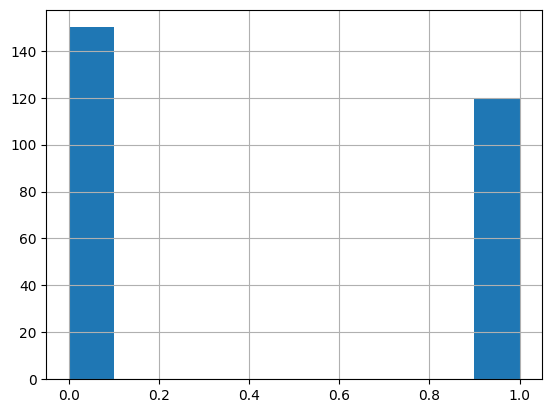

In [4]:
df['target'].hist()

<Axes: >

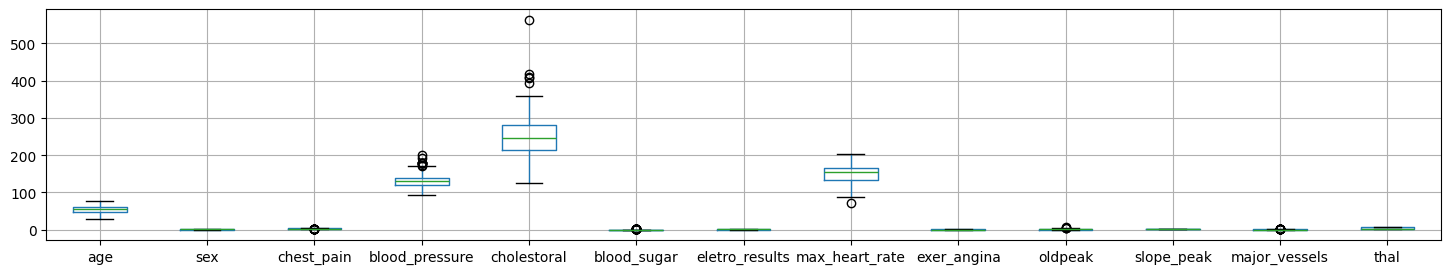

In [5]:
plt.figure(figsize=(18,3))
df[cols].boxplot()

<Axes: >

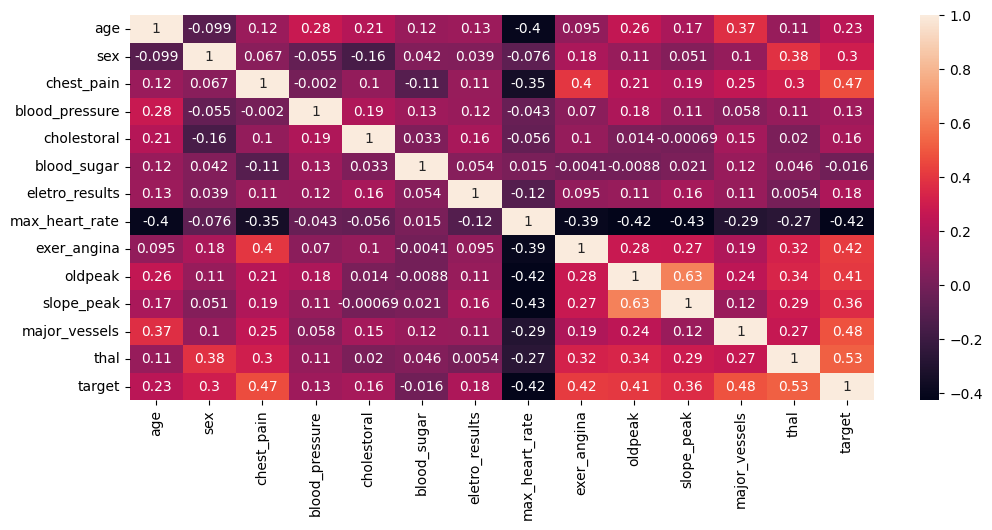

In [6]:
plt.figure(figsize=(12,5))
sns.heatmap(df.corr('spearman'), annot=True)

In [7]:
df.corr('spearman').dtypes

age               float64
sex               float64
chest_pain        float64
blood_pressure    float64
cholestoral       float64
blood_sugar       float64
eletro_results    float64
max_heart_rate    float64
exer_angina       float64
oldpeak           float64
slope_peak        float64
major_vessels     float64
thal              float64
target            float64
dtype: object

correlação regular entre:
- target e [chest_pain, max_heart_rate, exer_angina, oldpeak, major_vessels, thal]
- chest_pain e exer_angina
- max_heart_rate e [age, oldpeak, slope_peak]
- oldpeak e slope_peak

In [8]:
# 1/3 | 1/3 | 1/3
BASE_ASSESSOR_SPLIT = 0.3
BASE_TEST_SIZE = 0.5

temp = df[df.target==1]
train_pos, test_pos = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

temp = df[df.target==0]
train_neg, test_neg = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

Xb_train, Xb_test, yb_train, yb_test = train_test_split(pd.concat([train_pos[cols], train_neg[cols]], ignore_index=True), # X
                                                            pd.concat([train_pos['target'], train_neg['target']], ignore_index=True), # y
                                                            test_size=BASE_TEST_SIZE, shuffle=True, random_state=seed)

Xa_test = pd.concat([test_pos[cols], test_neg[cols]], ignore_index=True)
ya_test = pd.concat([test_pos['target'], test_neg['target']], ignore_index=True)

In [9]:
scaler = StandardScaler()

Xb_train_norm = scaler.fit_transform(Xb_train, yb_train)
Xb_test_norm = scaler.transform(Xb_test)

# se eu fosse normalizar os dados de teste do assessor, eu usaria o mesmo scaler?

# Base Models

In [10]:
performs = {}

In [11]:
pred_hits = pd.DataFrame()

In [12]:
def register_performance(train_set:list|tuple, test_set:list|tuple, model, model_name:str, pdict:dict=performs):
    assert (len(train_set)==2) & (len(test_set)==2)

    # train_set
    pred = model.predict(train_set[0])

    #try:
    #    pred_proba = model.predict_proba(train_set[0])[:, 1]
    #    pred_proba = [1-max(prob) for prob in pred_proba]
    #except AttributeError:
    #    pred_proba = model.decision_function(train_set[0])
    #    check = False
    #else:
    #    check = True

    pred_proba = model.predict_proba(train_set[0])
    minprob = [1-max(prob) for prob in pred_proba]

    metrics = compute_performance_metrics(train_set[1], pred, pred_proba[:,1])

    print('[Training]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name] = {'train': {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                   'recall':metrics[1],
                                   'precision':metrics[2], 'f1':metrics[3],
                                   'auroc':metrics[4], 'aupr':metrics[5]}}
    # test_set
    pred = model.predict(test_set[0])

    #if(check):
    pred_proba = model.predict_proba(test_set[0])
    minprob = [1-max(prob) for prob in pred_proba]
    #else:
    #    pred_proba = model.decision_function(test_set[0])

    metrics = compute_performance_metrics(test_set[1], pred, pred_proba[:,1])

    print('\n[Testing]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name]['test'] = {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                 'recall':metrics[1],
                                 'precision':metrics[2], 'f1':metrics[3],
                                 'auroc':metrics[4], 'aupr':metrics[5]}

### Decision Tree

In [13]:
dtree = DecisionTreeClassifier(random_state=seed).fit(Xb_train, yb_train)

In [14]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), dtree, 'dtree')

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0000
1-maxProb dp:     0.0000

[Testing]

Accuracy:         0.7789
Recall:           0.7660
Precision:        0.7826
F1:               0.7742
AUROC:            0.7788
AUPR:             0.7152
1-maxProb média:  0.0000
1-maxProb dp:     0.0000


In [15]:
pred_hits['dtree'] = dtree.predict(Xb_test) == yb_test
pred_hits.head()

,dtree
31,True
139,True
64,True
94,True
21,True


### Stochastic Gradient Descent
(SGD)

In [16]:
sgd = SGDClassifier(random_state=seed, loss='log_loss', n_jobs=-1).fit(Xb_train_norm, yb_train)

In [17]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), sgd, 'sgd')

[Training]

Accuracy:         0.8298
Recall:           0.7838
Precision:        0.7838
F1:               0.7838
AUROC:            0.9090
AUPR:             0.8539
1-maxProb média:  0.0209
1-maxProb dp:     0.0791

[Testing]

Accuracy:         0.8316
Recall:           0.7660
Precision:        0.8780
F1:               0.8182
AUROC:            0.8927
AUPR:             0.9113
1-maxProb média:  0.0113
1-maxProb dp:     0.0411


In [18]:
pred_hits['sgd'] = sgd.predict(Xb_test_norm) == yb_test

### Logistic Regression

In [19]:
lr = LogisticRegression(random_state=seed, n_jobs=-1).fit(Xb_train_norm, yb_train)

In [20]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), lr, 'lr')

[Training]

Accuracy:         0.8936
Recall:           0.8378
Precision:        0.8857
F1:               0.8611
AUROC:            0.9312
AUPR:             0.9128
1-maxProb média:  0.1397
1-maxProb dp:     0.1248

[Testing]

Accuracy:         0.8316
Recall:           0.7872
Precision:        0.8605
F1:               0.8222
AUROC:            0.9074
AUPR:             0.9158
1-maxProb média:  0.1725
1-maxProb dp:     0.1419


In [21]:
pred_hits['lr'] = lr.predict(Xb_test_norm) == yb_test

### K-Nearest Neighbors

(KNN)

In [22]:
knn = KNeighborsClassifier(n_jobs=-1).fit(Xb_train_norm, yb_train)

In [23]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), knn, 'knn')

[Training]

Accuracy:         0.8617
Recall:           0.7568
Precision:        0.8750
F1:               0.8116
AUROC:            0.9182
AUPR:             0.8575
1-maxProb média:  0.1383
1-maxProb dp:     0.1459

[Testing]

Accuracy:         0.8316
Recall:           0.7447
Precision:        0.8974
F1:               0.8140
AUROC:            0.8816
AUPR:             0.8775
1-maxProb média:  0.1642
1-maxProb dp:     0.1615


In [24]:
pred_hits['knn'] = knn.predict(Xb_test_norm) == yb_test

### Support Vector Machine - Linear
(SVM)

In [25]:
svm_linear = SVC(kernel='linear', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

In [26]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_linear , 'svm_linear')

[Training]

Accuracy:         0.8936
Recall:           0.8108
Precision:        0.9091
F1:               0.8571
AUROC:            0.9151
AUPR:             0.8968
1-maxProb média:  0.2192
1-maxProb dp:     0.1102

[Testing]

Accuracy:         0.8526
Recall:           0.8085
Precision:        0.8837
F1:               0.8444
AUROC:            0.9065
AUPR:             0.9190
1-maxProb média:  0.2464
1-maxProb dp:     0.1264


In [27]:
pred_hits['svm_linear'] = svm_linear.predict(Xb_test_norm) == yb_test

### Support Vector Machine - Polynomial
(SVM)

In [28]:
svm_poly = SVC(kernel='poly', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

In [29]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_poly, 'svm_poly')

[Training]

Accuracy:         0.9255
Recall:           0.8108
Precision:        1.0000
F1:               0.8955
AUROC:            0.9948
AUPR:             0.9921
1-maxProb média:  0.1458
1-maxProb dp:     0.1084

[Testing]

Accuracy:         0.7684
Recall:           0.5532
Precision:        0.9630
F1:               0.7027
AUROC:            0.8892
AUPR:             0.9073
1-maxProb média:  0.2181
1-maxProb dp:     0.1437


In [30]:
pred_hits['svm_poly'] = svm_poly.predict(Xb_test_norm) == yb_test

### Support Vector Machine - RBF
(SVM)

In [31]:
svm_rbf = SVC(kernel='rbf', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

In [32]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_rbf, 'svm_rbf')

[Training]

Accuracy:         0.9362
Recall:           0.8649
Precision:        0.9697
F1:               0.9143
AUROC:            0.9749
AUPR:             0.9735
1-maxProb média:  0.1365
1-maxProb dp:     0.0966

[Testing]

Accuracy:         0.8211
Recall:           0.7234
Precision:        0.8947
F1:               0.8000
AUROC:            0.9047
AUPR:             0.9081
1-maxProb média:  0.2054
1-maxProb dp:     0.1366


In [33]:
pred_hits['svm_rbf'] = svm_rbf.predict(Xb_test_norm) == yb_test

### Multi-Layer Perceptron
(MLP)

In [34]:
mlp = MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed).fit(Xb_train_norm, yb_train)

In [35]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), mlp, 'mlp')

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0180
1-maxProb dp:     0.0270

[Testing]

Accuracy:         0.8211
Recall:           0.7660
Precision:        0.8571
F1:               0.8090
AUROC:            0.8896
AUPR:             0.8995
1-maxProb média:  0.0854
1-maxProb dp:     0.1411


In [36]:
pred_hits['mlp'] = mlp.predict(Xb_test_norm) == yb_test

### Kolmogorov-Arnold Network
(KAN)

In [37]:
dataset = {'train_input': Xb_train_norm,
           'train_label': yb_train,
           'test_input': Xb_test_norm,
           'test_label': yb_test}

kanet = KANClassifier([13,200,2], lr=0.0001, lamb=0.005, random_state=seed)
kanet = kanet.fit(dataset)

| train_loss: 4.90e-01 | test_loss: 6.59e-01 | reg: 4.52e+01 | : 100%|█| 20/20 [00:30<00:00,  1.53s/


In [38]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), kanet, 'kan')

[Training]

Accuracy:         0.8936
Recall:           0.8108
Precision:        0.9091
F1:               0.8571
AUROC:            0.9706
AUPR:             0.9589
1-maxProb média:  0.1440
1-maxProb dp:     0.1368

[Testing]

Accuracy:         0.8000
Recall:           0.7872
Precision:        0.8043
F1:               0.7957
AUROC:            0.8905
AUPR:             0.8950
1-maxProb média:  0.1712
1-maxProb dp:     0.1641


In [39]:
pred_hits['kan'] = kanet.predict(Xb_test_norm) == yb_test

### Random Forest

In [40]:
rforest = RandomForestClassifier(random_state=seed, n_jobs=-1).fit(Xb_train, yb_train)

In [41]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), rforest, 'rforest')

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.1082
1-maxProb dp:     0.0896

[Testing]

Accuracy:         0.8000
Recall:           0.7021
Precision:        0.8684
F1:               0.7765
AUROC:            0.8703
AUPR:             0.8840
1-maxProb média:  0.2174
1-maxProb dp:     0.1461


In [42]:
pred_hits['rforest'] = rforest.predict(Xb_test) == yb_test

### Gradient Boosting

In [43]:
gb = GradientBoostingClassifier(random_state=seed).fit(Xb_train, yb_train)

In [44]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), gb, 'gb')

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0131
1-maxProb dp:     0.0132

[Testing]

Accuracy:         0.7684
Recall:           0.7234
Precision:        0.7907
F1:               0.7556
AUROC:            0.8426
AUPR:             0.8680
1-maxProb média:  0.0858
1-maxProb dp:     0.1229


In [45]:
pred_hits['gb'] = gb.predict(Xb_test) == yb_test

### AdaBoost

In [46]:
adab = AdaBoostClassifier(random_state=seed).fit(Xb_train, yb_train)

c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [47]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), adab, 'adab')

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.4535
1-maxProb dp:     0.0333

[Testing]

Accuracy:         0.7579
Recall:           0.7660
Precision:        0.7500
F1:               0.7579
AUROC:            0.8050
AUPR:             0.8173
1-maxProb média:  0.4632
1-maxProb dp:     0.0286


In [48]:
pred_hits['adab'] = adab.predict(Xb_test) == yb_test

### XGBoost

In [49]:
xgb = XGBClassifier(random_state=seed).fit(Xb_train, yb_train)

In [50]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), xgb, 'xgb')

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0380
1-maxProb dp:     0.0531

[Testing]

Accuracy:         0.7474
Recall:           0.7234
Precision:        0.7556
F1:               0.7391
AUROC:            0.8568
AUPR:             0.8714
1-maxProb média:  0.0989
1-maxProb dp:     0.1435


In [51]:
pred_hits['xgb'] = xgb.predict(Xb_test) == yb_test

## Análise de Correlações

In [52]:
pred_corrls = pd.DataFrame(columns=pred_hits.columns, index=pred_hits.columns, dtype=float)
size_preds = len(pred_hits)

for m in pred_hits.columns:
    for n in pred_hits.columns:
        pred_corrls.at[m,n] = ((pred_hits[m] == pred_hits[n]).sum())/size_preds

pred_corrls

,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
dtree,1.000000,0.778947,0.778947,0.778947,0.800000,0.736842,0.831579,0.789474,0.789474,0.810526,0.800000,0.789474,0.821053
sgd,0.778947,1.000000,0.894737,0.873684,0.873684,0.810526,0.863158,0.863158,0.863158,0.821053,0.747368,0.800000,0.768421
lr,0.778947,0.894737,1.000000,0.894737,0.936842,0.831579,0.905263,0.926316,0.926316,0.884211,0.852632,0.842105,0.831579
knn,0.778947,0.873684,0.894737,1.000000,0.894737,0.873684,0.926316,0.947368,0.863158,0.905263,0.852632,0.821053,0.831579
svm_linear,0.800000,0.873684,0.936842,0.894737,1.000000,0.831579,0.947368,0.926316,0.884211,0.905263,0.873684,0.842105,0.831579
svm_poly,0.736842,0.810526,0.831579,0.873684,0.831579,1.000000,0.884211,0.842105,0.800000,0.863158,0.789474,0.757895,0.768421
svm_rbf,0.831579,0.863158,0.905263,0.926316,0.947368,0.884211,1.000000,0.957895,0.873684,0.936842,0.884211,0.852632,0.863158
mlp,0.789474,0.863158,0.926316,0.947368,0.926316,0.842105,0.957895,1.000000,0.873684,0.894737,0.863158,0.831579,0.842105
kan,0.789474,0.863158,0.926316,0.863158,0.884211,0.800000,0.873684,0.873684,1.000000,0.873684,0.863158,0.873684,0.842105
rforest,0.810526,0.821053,0.884211,0.905263,0.905263,0.863158,0.936842,0.894737,0.873684,1.000000,0.905263,0.894737,0.884211


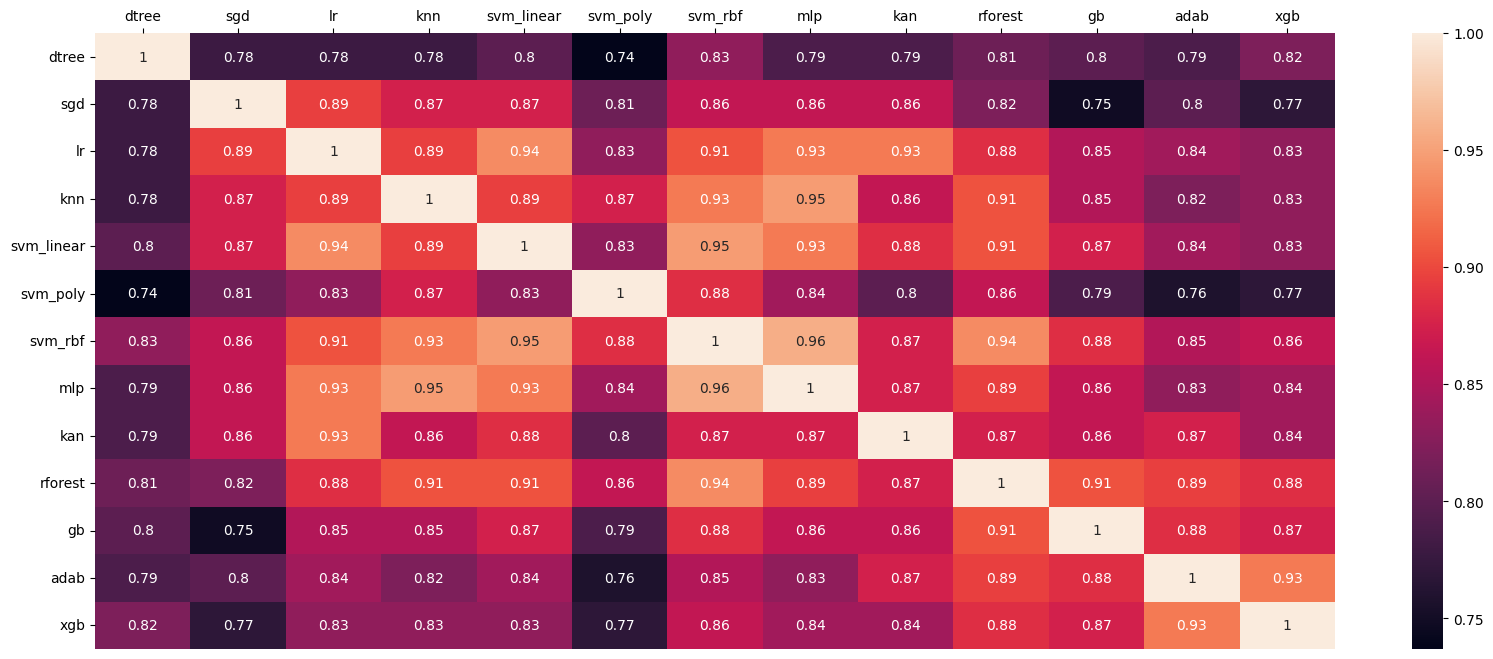

In [53]:
plt.figure(figsize=(20,8))
hm = sns.heatmap(pred_corrls, annot=True)
hm.xaxis.tick_top()

In [54]:
pred_corrls

,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
dtree,1.000000,0.778947,0.778947,0.778947,0.800000,0.736842,0.831579,0.789474,0.789474,0.810526,0.800000,0.789474,0.821053
sgd,0.778947,1.000000,0.894737,0.873684,0.873684,0.810526,0.863158,0.863158,0.863158,0.821053,0.747368,0.800000,0.768421
lr,0.778947,0.894737,1.000000,0.894737,0.936842,0.831579,0.905263,0.926316,0.926316,0.884211,0.852632,0.842105,0.831579
knn,0.778947,0.873684,0.894737,1.000000,0.894737,0.873684,0.926316,0.947368,0.863158,0.905263,0.852632,0.821053,0.831579
svm_linear,0.800000,0.873684,0.936842,0.894737,1.000000,0.831579,0.947368,0.926316,0.884211,0.905263,0.873684,0.842105,0.831579
svm_poly,0.736842,0.810526,0.831579,0.873684,0.831579,1.000000,0.884211,0.842105,0.800000,0.863158,0.789474,0.757895,0.768421
svm_rbf,0.831579,0.863158,0.905263,0.926316,0.947368,0.884211,1.000000,0.957895,0.873684,0.936842,0.884211,0.852632,0.863158
mlp,0.789474,0.863158,0.926316,0.947368,0.926316,0.842105,0.957895,1.000000,0.873684,0.894737,0.863158,0.831579,0.842105
kan,0.789474,0.863158,0.926316,0.863158,0.884211,0.800000,0.873684,0.873684,1.000000,0.873684,0.863158,0.873684,0.842105
rforest,0.810526,0.821053,0.884211,0.905263,0.905263,0.863158,0.936842,0.894737,0.873684,1.000000,0.905263,0.894737,0.884211


In [55]:
corrls_values = pd.Series(pred_corrls.values.reshape((169,)))
corrls_values.describe()

count    169.000000
mean       0.865961
std        0.062534
min        0.736842
25%        0.831579
50%        0.863158
75%        0.894737
max        1.000000
dtype: float64

<Axes: >

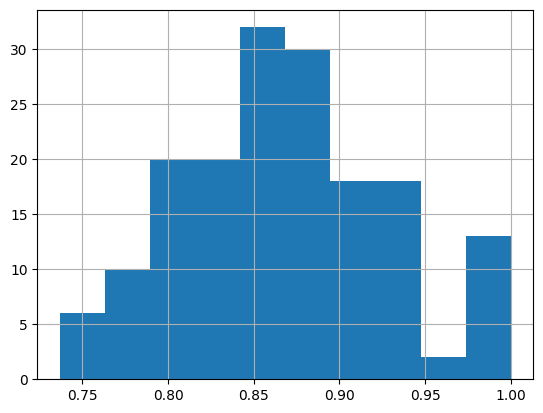

In [57]:
corrls_values.hist()

Se for pegar um grupo para analisar, tentar usar como a correlação mínima entre previsões o 3º quantil, o que daria por volta de  (no caso atual)

AttributeError: 'float' object has no attribute 'isna'

In [100]:
all_listas = []

def unsqueeze(lista):
    global all_listas
    if(type(lista[0])!=list):
        all_listas.append(lista)
    else:
        if(len(lista)==1):
            unsqueeze(lista[0])
        else:
            for i in range(len(lista)):
                unsqueeze(lista[i])
            
        
#def unsqueeze(lista):
#    while
                

unsqueeze([[[[1,2]], [2,1]], [3]])

all_listas

[[1, 2], [2, 1], [3]]

In [95]:
unsqueeze([[[1, 2], [2, 1]], [3]])

[[[1, 2], [2, 1]], [3]]

In [106]:
def group_search_help(df:pd.DataFrame, min_score:int, models:list|set=None, base_group:list=[]):
    if(models is None):
        models = ['dtree', 'sgd', 'lr', 'knn', 'svm_linear', 'svm_poly', 'svm_rbf', 'mlp',
                  'kan', 'rforest', 'gb', 'adab', 'xgb']
    
    if(len(base_group)==0):
        base_group, models = models[:1], models[1:]
    
    output_groups = []

    for m in models:
        i = 0
        check = True
        while(check and i<len(base_group)):
            corr = df.at[base_group[i],m]
            if(np.isnan(corr)):
                check = False
            elif(corr < min_score):
                check = False
            i+=1
        if(check):
            temp = models.copy()
            temp.remove(m)
            output_groups.append(group_search_help(df, min_score, temp, base_group+[m]))

    if(len(output_groups)==0):
        return base_group

    return output_groups




def group_search(df:pd.DataFrame, min_score:int, models:list=None):
    if(models is None):
        models_dict = {'dtree':0, 'sgd':0, 'lr':0, 'knn':0, 'svm_linear':0, 'svm_poly':0, 'svm_rbf':0, 'mlp':0,
                  'kan':0, 'rforest':0, 'gb':0, 'adab':0, 'xgb':0}
        models = ['dtree', 'sgd', 'lr', 'knn', 'svm_linear', 'svm_poly', 'svm_rbf', 'mlp',
                  'kan', 'rforest', 'gb', 'adab', 'xgb']
    
    df.map(lambda x: np.NAN if x<min_score else x)

    groups = []
    for i in range(len(models)):
        groups.append(group_search_help(df, min_score, models[i:]))
        #if(type(new_group[0])==list):
        #groups += new_group
        #for n in groups[-1]:
        #    if(n in models):
        #        models.remove(n)
    return groups

groups_list = []

def unsqueeze(lista):
    global groups_list
    if(type(lista[0])!=list):
        groups_list.append(lista)
    else:
        if(len(lista)==1):
            unsqueeze(lista[0])
        else:
            for i in range(len(lista)):
                unsqueeze(lista[i])

In [102]:
min_score = corrls_values.quantile(0.75)

pred_corrls_min = pred_corrls.map(lambda x: np.NAN if (x<min_score) or (x==1) else x)

print('Min_score:', min_score)

pred_corrls_min

Min_score: 0.8947368421052632


,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
dtree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sgd,NaN,NaN,0.894737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lr,NaN,0.894737,NaN,0.894737,0.936842,NaN,0.905263,0.926316,0.926316,NaN,NaN,NaN,NaN
knn,NaN,NaN,0.894737,NaN,0.894737,NaN,0.926316,0.947368,NaN,0.905263,NaN,NaN,NaN
svm_linear,NaN,NaN,0.936842,0.894737,NaN,NaN,0.947368,0.926316,NaN,0.905263,NaN,NaN,NaN
svm_poly,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
svm_rbf,NaN,NaN,0.905263,0.926316,0.947368,NaN,NaN,0.957895,NaN,0.936842,NaN,NaN,NaN
mlp,NaN,NaN,0.926316,0.947368,0.926316,NaN,0.957895,NaN,NaN,0.894737,NaN,NaN,NaN
kan,NaN,NaN,0.926316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rforest,NaN,NaN,NaN,0.905263,0.905263,NaN,0.936842,0.894737,NaN,NaN,0.905263,0.894737,NaN


In [108]:
unsqueeze(group_search(pred_corrls_min, min_score))

groups_list

[['dtree'],
 ['sgd', 'lr'],
 ['lr', 'knn', 'svm_linear', 'svm_rbf', 'mlp'],
 ['lr', 'knn', 'svm_linear', 'mlp', 'svm_rbf'],
 ['lr', 'knn', 'svm_rbf', 'svm_linear', 'mlp'],
 ['lr', 'knn', 'svm_rbf', 'mlp', 'svm_linear'],
 ['lr', 'knn', 'mlp', 'svm_linear', 'svm_rbf'],
 ['lr', 'knn', 'mlp', 'svm_rbf', 'svm_linear'],
 ['lr', 'svm_linear', 'knn', 'svm_rbf', 'mlp'],
 ['lr', 'svm_linear', 'knn', 'mlp', 'svm_rbf'],
 ['lr', 'svm_linear', 'svm_rbf', 'knn', 'mlp'],
 ['lr', 'svm_linear', 'svm_rbf', 'mlp', 'knn'],
 ['lr', 'svm_linear', 'mlp', 'knn', 'svm_rbf'],
 ['lr', 'svm_linear', 'mlp', 'svm_rbf', 'knn'],
 ['lr', 'svm_rbf', 'knn', 'svm_linear', 'mlp'],
 ['lr', 'svm_rbf', 'knn', 'mlp', 'svm_linear'],
 ['lr', 'svm_rbf', 'svm_linear', 'knn', 'mlp'],
 ['lr', 'svm_rbf', 'svm_linear', 'mlp', 'knn'],
 ['lr', 'svm_rbf', 'mlp', 'knn', 'svm_linear'],
 ['lr', 'svm_rbf', 'mlp', 'svm_linear', 'knn'],
 ['lr', 'mlp', 'knn', 'svm_linear', 'svm_rbf'],
 ['lr', 'mlp', 'knn', 'svm_rbf', 'svm_linear'],
 ['lr', 'mlp

fazer com que todos os modelos do grupo tenham uma correlação acima do score mínimo entre todos eles? Ou fazer com que o próximo modelo encontrado do grupo tenha uma correlação acima do mínimo com o modelo mais recente?

(provavelmente o primeiro)

# Assessors

## Globais

### Regressor Chain
(RC)

In [ ]:
regchain = 

### Multi-Output Regressor 
(ST)

## Individuais

## Grupais